## Алгоритм действий при решении задачи:
### - Связать точки на карте между собой и создать тем самым граф
### - Наложить этот граф на карту г.Нур-Султан
### - Разработать гипотезы об определении некорректных маршрутов
### - Классифицировать некорректные маршруты на телепорты и разрывы
### - Найти соответсвие и взаимовлияние телепортов и разрывов
### - На базе полученных результатов разделить датасет на грязные и чистые данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, delaunay_plot_2d
import networkx as nx
import mplleaflet
from haversine import haversine, Unit
import seaborn as sns
import datetime
from tqdm import tqdm

df = pd.read_csv('Astana_IT_University.csv')
df.head()

,guid,time,latitude,longitude
0,7478838619590907462,2021-04-01 07:36:11,51.159332,71.473405
1,2997461076110774059,2021-04-01 09:56:18,51.134324,71.407551
2,17682486554924796428,2021-04-01 00:32:52,51.146719,71.417827
3,397461470620689040,2021-04-01 14:30:12,51.085519,71.407242
4,15826732787680471725,2021-04-01 15:52:04,51.120081,71.467297


## 1. Связать точки на карте между собой и создать тем самым граф

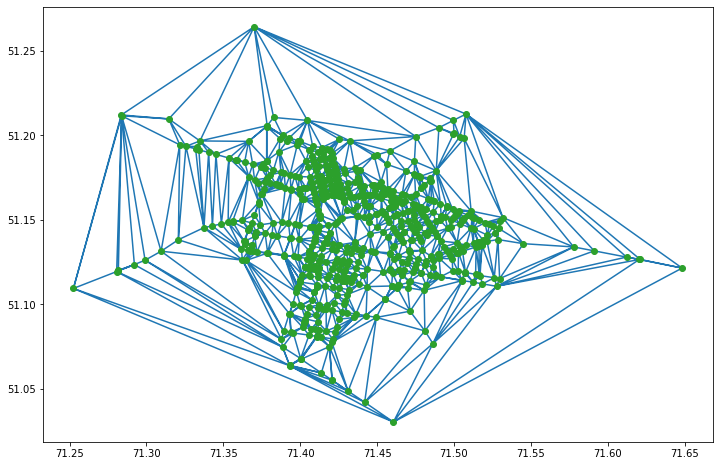

In [2]:
# Методом триангуляции Делоне объединили точки и показали предварительный вид

cameras = df.groupby(['longitude', 'latitude'], as_index=False).count()[['longitude', 'latitude']].values
tri = Delaunay(cameras)
fig1 = plt.figure(figsize=(12, 8))
plt.triplot(cameras[:,0], cameras[:,1], tri.simplices)
plt.plot(cameras[:,0], cameras[:,1], 'o')

In [ ]:
# Процесс создания Графа с вершинами и ребрами

edges = []
for elem in tri.vertices:
    A = str(tuple(cameras[elem[0]]))
    B = str(tuple(cameras[elem[1]]))
    C = str(tuple(cameras[elem[2]]))
    edges.append([A, B])
    edges.append([A, C])
    edges.append([B, C])

graph = pd.DataFrame(edges, columns=['node1', 'node2'])
graph['path'] = graph['node1'] + ':' + graph['node2']
graph['path'] = graph['path'].apply(lambda x: x.split(':'))
graph['path'] = graph['path'].apply(lambda x: sorted(x))

def calculateDistance(x):
    long1 = float(x.split(':')[0].split(',')[0][1:])
    lat1 = float(x.split(':')[0].split(',')[1][1:-1])
    
    long2 = float(x.split(':')[1].split(',')[0][1:])
    lat2 = float(x.split(':')[1].split(',')[1][1:-1])
    
    return haversine((lat1, long1), (lat2, long2))

graph['node1'] = graph['path'].apply(lambda x: x[0])
graph['node2'] = graph['path'].apply(lambda x: x[1])
graph = graph.groupby(['node1', 'node2'], as_index=False).count()

graph['path'] = graph['node1'] + ':' + graph['node2']
graph['distance'] = graph['path'].apply(lambda x: calculateDistance(x))
graph.drop(['path'], axis=1, inplace=True)
graph['position1'] = graph['node1']
graph['position2'] = graph['node2']

def coord1(x):
    test_list = x.strip(')(').split(', ')
    test_list = tuple(map(float, test_list))
    return test_list

graph['position1'] = graph['node1'].apply(lambda x: coord1(x))
graph['position2'] = graph['node2'].apply(lambda x: coord1(x))

G = nx.from_pandas_edgelist(graph, 'node1', 'node2', ['distance'])
for index, row in graph.iterrows():
    G.nodes[row['node1']]['position'] = row['position1']
    G.nodes[row['node2']]['position'] = row['position2']    

## 2. Наложить граф на карту г.Нур-Султан

In [3]:
# Наложение графа на интерактивную карту
fig, ax = plt.subplots()

nx.draw_networkx_nodes(G,pos=nx.get_node_attributes(G, 'position'),node_size=30,node_color='red')
nx.draw_networkx_edges(G,pos=nx.get_node_attributes(G, 'position'),edge_color='gray')
nx.draw_networkx_labels(G,pos=nx.get_node_attributes(G, 'position'))

mplleaflet.display(fig=ax.figure) 

C:\Users\Acer\anaconda3\lib\site-packages\mplleaflet\mplexporter\exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## 3. Разработать гипотезы об определении некорректных маршрутов

In [5]:
# Импортировали CSV файл о маршрутах данного датасета
route = pd.read_csv('full(1).csv', index_col=0)
route['guid'] = route['guid'].apply(lambda x: x[:-1])
route['latitude'] = route['latitude'].apply(lambda x: x[:-1])
route['longitude'] = route['longitude'].apply(lambda x: x[:-1])
route['latitude1'] = route['latitude1'].apply(lambda x: x[:-1])
route['longitude1'] = route['longitude1'].apply(lambda x: x[:-1])
route = route[route['distance'] > 0]
noroute = route[route['distance'] == 0]
route.drop(['guid1', 'distance', 'time_taken'], axis=1, inplace=True)
route.head()

,guid,time,latitude,longitude,time1,latitude1,longitude1
0,138949444128,2021-04-01 08:07:25,51.15862475811304,71.44194337649681,2021-04-01 15:27:15,51.14907780966893,71.47033056851846
2,688310978564,2021-04-01 10:24:42,51.159473547866256,71.49115888484958,2021-04-01 10:25:07,51.16105369865436,71.48720400872709
4,688310978564,2021-04-01 10:25:11,51.16105369865436,71.48720400872709,2021-04-01 10:25:17,51.16178603774237,71.48525960882039
6,688310978564,2021-04-01 10:25:23,51.16178603774237,71.48525960882039,2021-04-01 10:28:06,51.16338675476855,71.4717721939087
7,688310978564,2021-04-01 10:28:06,51.16338675476855,71.4717721939087,2021-04-01 10:30:05,51.16240362730085,71.46421059140785


In [7]:
# Применили функцию для определения корректных маршрутов
route['path'] = '(' + route['longitude'].astype(str) + ', ' + route['latitude'].astype(str) + ')' + ':' + '(' + route['longitude1'].astype(str) + ', ' + route['latitude1'].astype(str) + ')' 

def isValid(x):
    if nx.shortest_path_length(G, source=x.split(':')[0], target=x.split(':')[1]) > 3:
        return 'Invalid'
    else:
        return 'Valid'

route['isValid'] = route['path'].apply(lambda x: isValid(x))
route.isValid.value_counts()

Valid      1360337
Invalid     249336
Name: isValid, dtype: int64

## 4. Классифицировать некорректные маршруты на телепорты и разрывы

In [21]:
first = route.iloc[:-1][['guid']]
second = route.iloc[1:][['guid']]
loop = zip(first.index.to_list(), first['guid'], second.index.to_list(), second['guid'])
route['class'] = route['isValid'].apply(lambda x: 'Teleport' if x=='Invalid' else 'Normal')

In [22]:
for findex, fguid, sindex, sguid in loop:
    fisValid = route.at[findex, 'isValid']
    sisValid = route.at[sindex, 'isValid']
    if fguid == sguid:
        if (fisValid == 'Invalid') & (sisValid == 'Valid'):
            route.at[findex, 'class'] = 'Window'
            route.at[findex, 'isValid'] = 'Valid'
        elif (fisValid == 'Invalid') & (sisValid == 'Invalid'):
            route.at[findex, 'class'] = 'Teleport'
            route.at[findex, 'isValid'] = 'Valid'
        else:
            route.at[findex, 'class'] = 'Normal'
    else:
        pass   

In [23]:
route['isValid'] = route['path'].apply(lambda x: isValid(x))
route['class'].value_counts()

Normal      1360337
Window       151565
Teleport      97771
Name: class, dtype: int64

## Найти соответсвие и взаимовлияние телепортов и разрывов